In [60]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, md5, sum as _sum
import matplotlib.pyplot as plt
import os

# Extracción de datos

# 1. Crear SparkSession
spark = SparkSession.builder.appName("GrandataSMS").getOrCreate()

# 2. Cargar datasets
df_events = spark.read.option("header", True).csv("/app/data/events.csv.gz", inferSchema=True)
df_free_sms_destinations = spark.read.option("header", True).csv("/app/data/free_sms_destinations.csv.gz", inferSchema=True)



In [61]:
# Limpieza de Datos y Creación del modelo base

# 3. Limpiar registros nulos
df_events = df_events.filter(col("id_source").isNotNull() & col("id_destination").isNotNull())

# 4. Marcar destinos gratuitos
df_free_sms_destinations = df_free_sms_destinations.withColumnRenamed("id", "id_destination")
df_events = df_events.join(df_free_sms_destinations.withColumn("is_free", lit(True)), on="id_destination", how="left")
df_events = df_events.withColumn("is_free", when(col("is_free").isNull(), False).otherwise(True))


# 5. Calcular el costo por sms
df_events = df_events.withColumn(
    "sms_unit_cost",
    when(col("is_free"), 0.0)
    .when(col("region").between(1, 5), 1.5)
    .when(col("region").between(6, 9), 2.0)
    .otherwise(0.0)
)

# 6. Calcular costo total por fila
df_events = df_events.withColumn("sms_total_cost", col("sms") * col("sms_unit_cost"))


In [62]:
# Crear carpetas de salida si no existen
os.makedirs("../output", exist_ok=True)

# -------------------------------
# ✅ PUNTO 1: monto total facturado
# -------------------------------
total_amount = df_events.agg({"sms_total_cost": "sum"}).collect()[0][0]
print(f"Monto total a facturar: ${total_amount:.2f}")

# # Guardar el monto en un .txt para el README
# with open("../output/monto_total.txt", "w") as f:
#     f.write(f"Monto total a facturar: ${total_amount:.2f}\n")


Monto total a facturar: $391367.00


In [63]:
# -------------------------------
# ✅ PUNTO 2: Top 100 usuarios por facturación
# -------------------------------
df_usuarios = df_events.groupBy("id_source") \
    .agg(_sum("sms_total_cost").alias("monto_facturado")) \
    .orderBy(col("monto_facturado").desc()) \
    .limit(100)

# Agregar ID hasheado en MD5
df_usuarios = df_usuarios.withColumn("id_md5", md5(col("id_source")))

# Guardar en Parquet con compresión gzip
df_usuarios.write.mode("overwrite").option("compression", "gzip") \
    .parquet("../output/top_100_usuarios.parquet")

print("Top 100 exportado como Parquet.")


Top 100 exportado como Parquet.


In [64]:
# Probar el dataset
df_top_100 = spark.read.parquet("../output/top_100_usuarios.parquet")
df_top_100.show(5)

+---------+---------------+--------------------+
|id_source|monto_facturado|              id_md5|
+---------+---------------+--------------------+
|      4D3|        23403.0|911914c7729eedbdf...|
|      76D|        13664.0|bd180b7811395cbce...|
|      07E|         4226.0|14a0660ae2f5d1868...|
|      541|         2526.0|16c222aa19898e505...|
|      C25|         2019.0|0bfa0b57d99985aa1...|
+---------+---------------+--------------------+
only showing top 5 rows



📈 Histograma guardado como PNG.


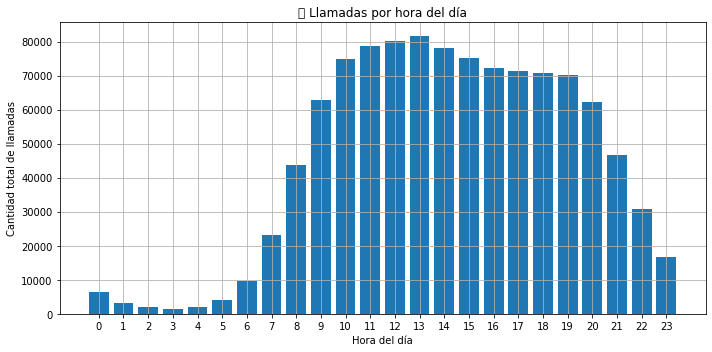

In [65]:
# -------------------------------
# ✅ PUNTO 3: Histograma de llamadas por hora
# -------------------------------
df_llamadas_por_hora = df_events.groupBy("hour").agg({"calls": "sum"}).orderBy("hour")
calls_by_hour = df_llamadas_por_hora.toPandas()

# Graficar
plt.figure(figsize=(10,5))
plt.bar(calls_by_hour["hour"], calls_by_hour["sum(calls)"])
plt.xlabel("Hora del día")
plt.ylabel("Cantidad total de llamadas")
plt.title("📊 Llamadas por hora del día")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/histograma_llamadas_por_hora.png", facecolor='white')
print("📈 Histograma guardado como PNG.")